## (In)elastic analysis

In [34]:
%load_ext autoreload
%autoreload 2
import pyphysics as phys

import pandas as pd
import uproot
import hist
import matplotlib.pyplot as plt
import numpy as np
import uncertainties as un

import ROOT as r


df = pd.read_csv("./sidesil.csv")
df.loc[:, "angle"] = None
df.loc[:, "tpc"] = None
df.loc[:, "line"] = None
df.loc[:, "qave"] = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# Processed
proc = df.loc[df["type"].notna()]
print(f"Processed : {len(proc)}")

Processed : 1396


/tmp/ipykernel_31843/3654658333.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, counts, fr"{percents[i]:.2f} \%", ha="center", va="bottom", fontdict=dict(size=12))


Binary proportion: 43.77


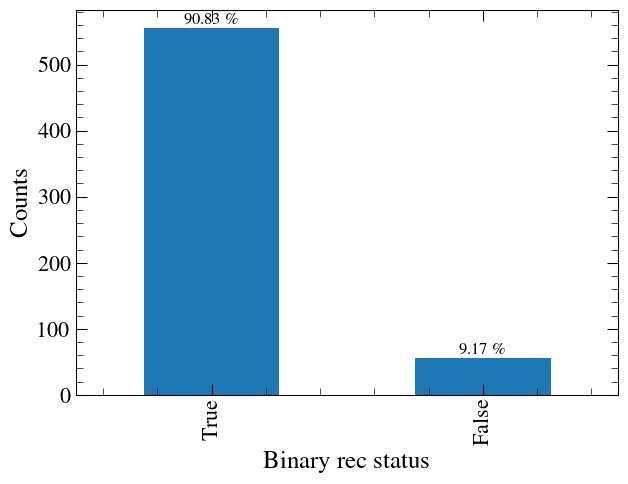

In [ ]:
bina = df.loc[df["type"] == "Binary"]
stats = bina["status"].value_counts()
percents = stats / stats.sum() * 100
# Plot
stats.plot.bar(xlabel="Binary rec status", ylabel="Counts")
for i, counts in enumerate(stats.values):
    plt.text(i, counts, fr"{percents[i]:.2f} \%", ha="center", va="bottom", fontdict=dict(size=12))

print(f"Binary proportion: {len(bina) / len(proc) * 100:0.2f}")

In [40]:
ok_bina = len(bina.loc[bina["status"] == True])
eff = un.ufloat(ok_bina, un.umath.sqrt(ok_bina))
eff /= len(bina)
print(f"Eff : {eff*100:%.2uS}")

Eff : 90.8(3.9)


In conclusion, we have 90 % efficiency for elastic events. But can we explain them?

In [3]:
# Read root file
data = uproot.open("../../../Macros/PID/Outputs/sidesil.root:SimpleTree")
root = data.arrays(library="pd")
root["fRun"] = root["fRun"].astype(int)
root["fEntry"] = root["fEntry"].astype(int)


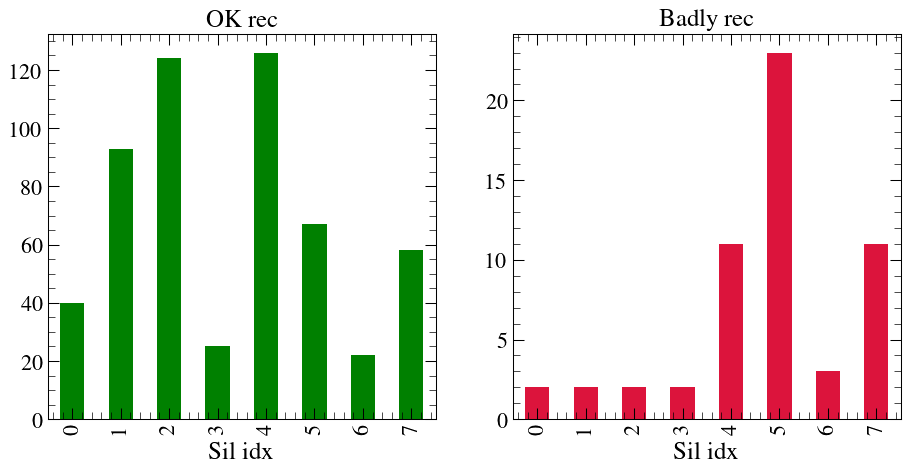

In [4]:
# Inspection by silicon index

fig, axs = plt.subplots(1, 2, figsize=(11,5))

both = []
titles = ["OK rec", "Badly rec"]
colors = ["green", "crimson"]
for i, status in enumerate([True, False]):
    ax = axs.flatten()[i]
    gated = bina.loc[bina["status"] == status]
    both.append(gated)
    root.loc[gated.index, "N0"].value_counts().sort_index().plot.bar(ax=ax, title=titles[i], xlabel="Sil idx", color=colors[i])

In [5]:
# Inspection by silicon energy

hBadE = hist.Hist(hist.axis.Regular(50, 0, 10, name="ESil0", label="ESil0 [MeV]"))
hBadE.fill(root.loc[both[-1].index, "E0"].values)

Hist(Regular(50, 0, 10, name='ESil0', label='ESil0 [MeV]'), storage=Double()) # Sum: 56.0

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x77221dc09cf0>, errorbar=None, legend_artist=None)]

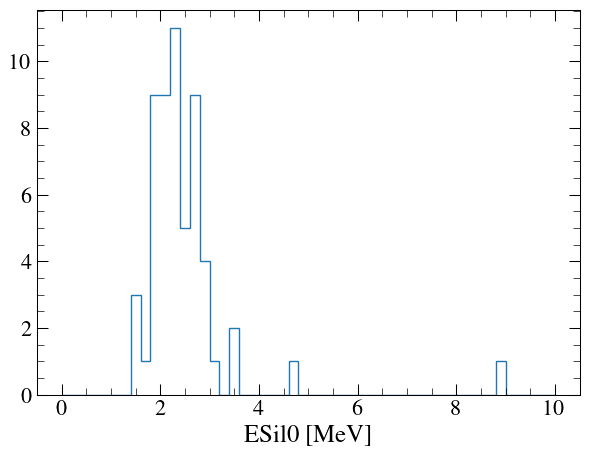

In [6]:
plt.figure()
hBadE.plot(yerr=False)

A few conclusion can be drawn:
- Regarding the silicon pad, seems that silicon number 5 loses most of the events! We have noticed something similar time ago and we concluded it was related to the beam dump: this silicon receives most of the reactions from the beam dump and this could interfere with the reacting particles; either by "dead-time" or by coincidence (less likely). 
It might be related to the fact that this silicon receives tracks with smaller $\theta$ angles, corresponding to **high-energy particles**. 

- The silicon energy plot confirms tracks have a small energy deposit. According to the kinematical plots in this regions, this would correspond to low p/d from excited states and/or particles undergoing punch-through!

Next section attempts to reconstruct these missing events by applying RANSAC. Then, energy-angle correlations can be established and this could be better explained

### Fast reconstruction of events with RANSAC

In [7]:
dataman = phys.DataManInterface("../../../configs/data.conf", "tpc", (155, 165))
tpc = r.ActRoot.TPCData()
dataman.set_branch_address("TPCData", tpc)

To simplify RANSAC, a selection on the upper pad region $Y \in [85, 120]$ was made. However, this doesn't allow to have a comparable PID since part of the tracks would be missing. Furthermore, this simplified calculation doesn't enable track-length computations yet.

In [81]:
def run_ransac(tpc):
    voxels = []
    ycut = (80, 128)
    # Noise
    for v in tpc.fRaw:
        y = v.GetPosition().Y()
        if ycut[0] <= y <= ycut[1]:
            voxels.append(v)
    # Clusters
    for c in tpc.fClusters:
        for v in c.GetVoxels():
            y = v.GetPosition().Y()
            if ycut[0] <= y <= ycut[1]:
                voxels.append(v)
    # And call ransac
    ransac = r.ActAlgorithm.RANSAC(275, 12, 2.5) #type:ignore
    cl, _ = ransac.Run(voxels)
    # Get cluster with lowest chi2
    aux = 1111
    ret = None
    for c in cl:
        nvoxels = c.GetSizeOfVoxels()
        chi2 = c.GetLine().GetChi2()
        if chi2 < aux:
            aux = chi2
            ret = c
    return ret

def get_theta(line: phys.LineInterface) -> float:
    xdir = np.array([1, 0, 0])
    v = line.fDir
    ## Convert to mm units
    v[:2] *= 2
    v[2] *= 2.469
    dot = np.clip(np.dot(v, xdir) / np.linalg.norm(v), -1, 1)
    return np.degrees(np.arccos(dot))
    

def get_qave(cl) -> float:
    cl.SortAlongDir()
    first = cl.GetVoxels().front().GetPosition()
    last = cl.GetVoxels().back().GetPosition()
    ## Scale to physical
    for p in [first, last]:
        p.SetX(p.X() * 2)
        p.SetY(p.Y() * 2)
        p.SetZ(p.Z() * 2.469)
    dist = (first - last).R()
    q = sum(v.GetCharge() for v in cl.GetVoxels())
    # print(f"Q : {q:.2f} dist : {dist:.2f}")
    return q / dist

# Badly identified events
bad: pd.DataFrame = both[-1]

for i, index in enumerate(bad.index):
    run, entry = root.at[index, "fRun"], root.at[index, "fEntry"]
    # Ensure run and entry match
    otherRun, otherEntry = bad.at[index, "run"], bad.at[index, "entry"]
    if otherRun != run or otherEntry != entry:
        continue
    dataman.get_run_entry(run, entry)
    ret = run_ransac(tpc)
    # Write TPC data in form of histogram
    bad.at[index, "tpc"] = phys.TPCInterface(tpc)
    # Write line if any new cluster has been formed
    if ret:
        line = ret.GetLine()
        line.AlignUsingPoint(r.Math.XYZPointF(0, 64, 64)) #type: ignore
        aux = phys.LineInterface(line)
        bad.at[index, "line"] = aux

        # Theta
        theta = get_theta(aux)
        bad.at[index, "angle"] = theta

        # Q that is not Qave but Qsum but I forgot....
        bad.at[index, "qave"] = get_qave(ret)


The next figure shows a selection of **badly identified** events, along with the fit recovered by using RANSAC. Sometimes it fails, especially when there is a high level of noise

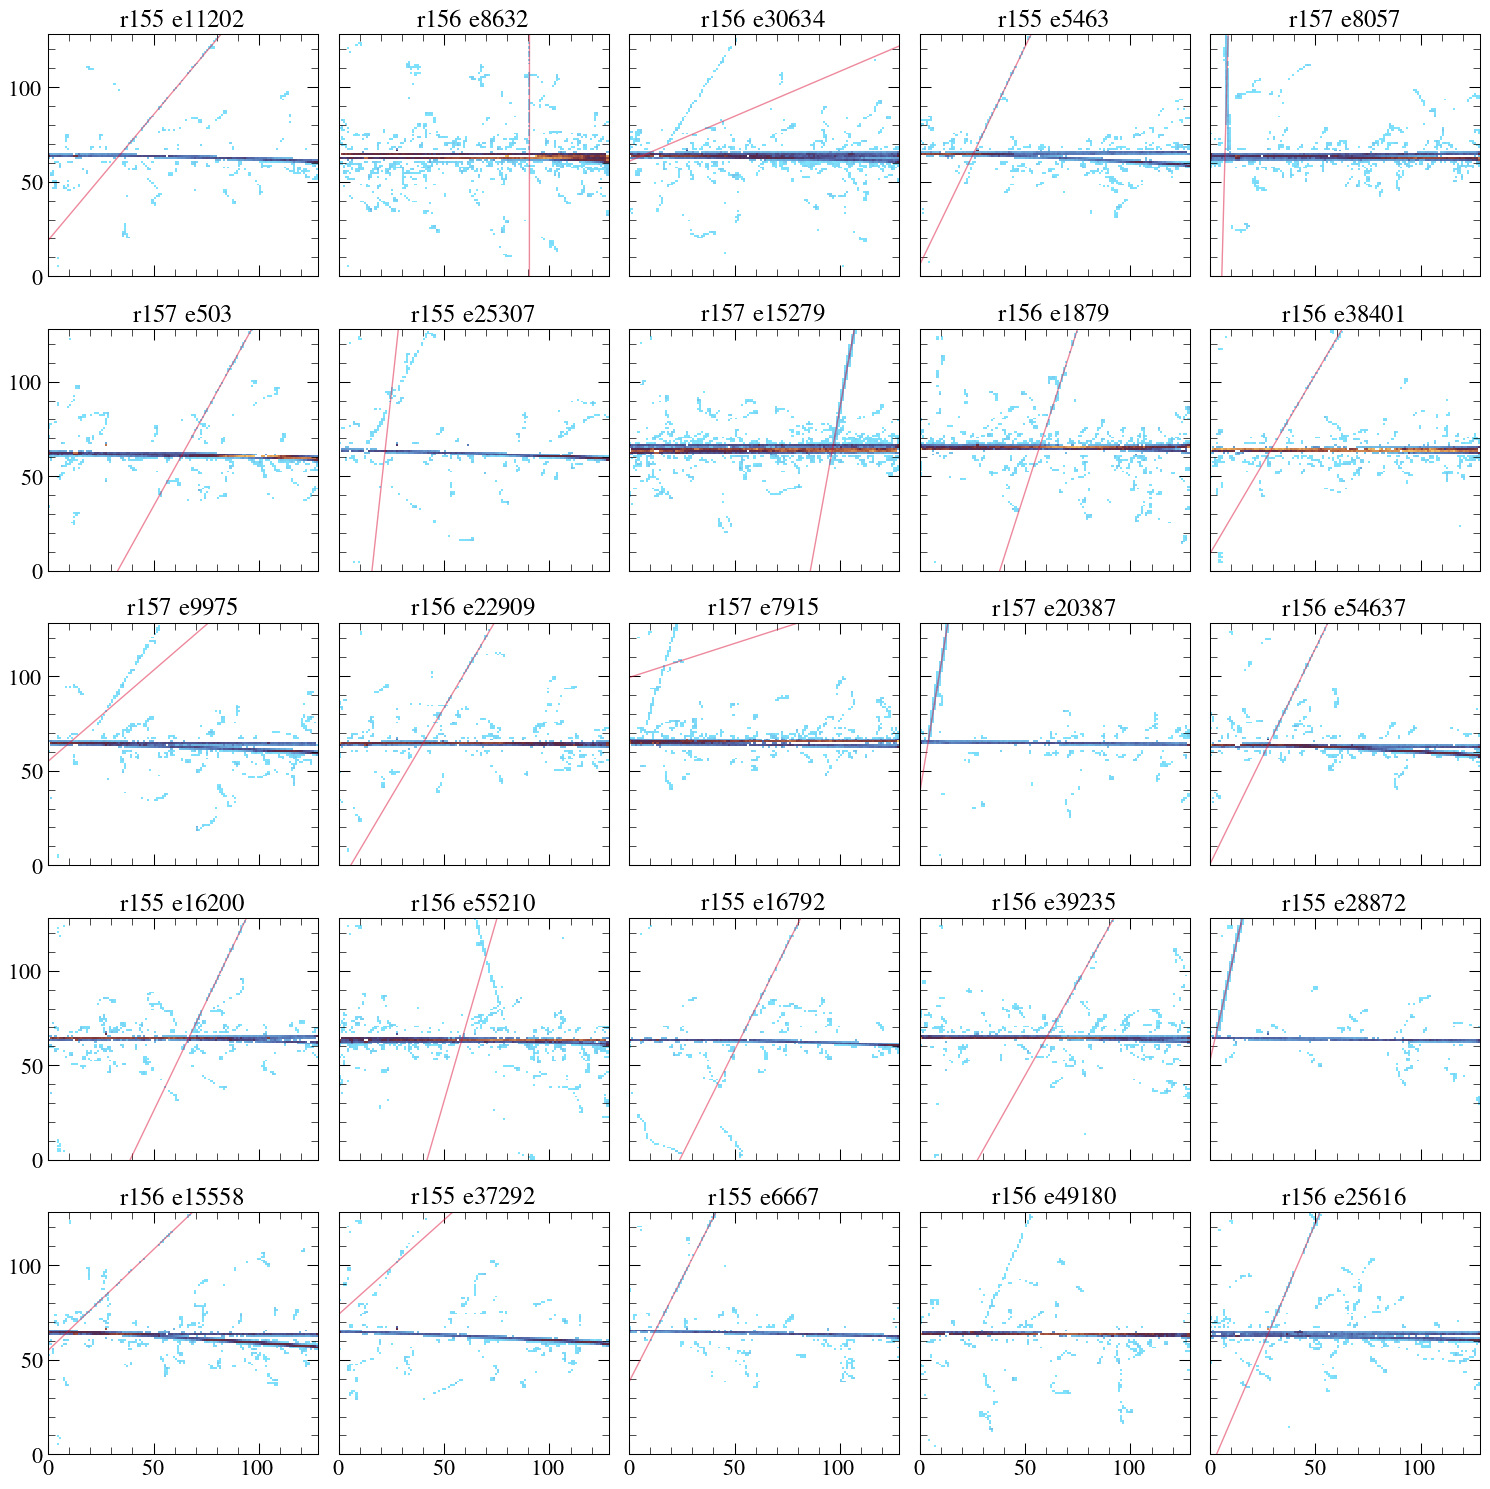

In [82]:
# Plot
n = 5
m = 5

to_plot = bad.sample(n=n*m).index

fig, axs = plt.subplots(n, m, figsize=(15, 15), sharex=True, sharey=True)
for i, index in enumerate(to_plot):
    ax = axs.flatten()[i]
    run = bad.at[index, "run"]
    entry = bad.at[index, "entry"]
    angle = bad.at[index, "angle"]
    # TPC
    bad.at[index, "tpc"].plot(proj="xy", ax=ax, cbar=False)
    # Lines
    if bad.at[index, "line"]:
        bad.at[index, "line"].plot(color="crimson", alpha=0.5)
        # Axis formatting
    ax.set_title(fr"r{run} e{entry}")
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.tight_layout()


### Comparison with experiment and simulations

The bad events are compared with a plot of the experimental $\Delta E$ vs $\theta$. Energy at the vertex isn't computed because we can't reconstruct it without knowing which particle (p or d) the track corresponds to. $\theta$ comes from RANSAC reconstruction, without having considered the beam angle. Some events have been poorly reconstructed. 

In [83]:
# Read experimental dataset
exps = []
for file in ["tree_20O_1H_1H_side_juan_RPx.root", "tree_20O_2H_2H_side_juan_RPx.root"]:
    up = uproot.open(f"../../../PostAnalysis/RootFiles/Pipe3/{file}:Sel_Tree")
    exps.append(up.arrays(["fSilEs", "EVertex", "fThetaLight"], library="pd"))

rootbad = root.loc[bad.index]


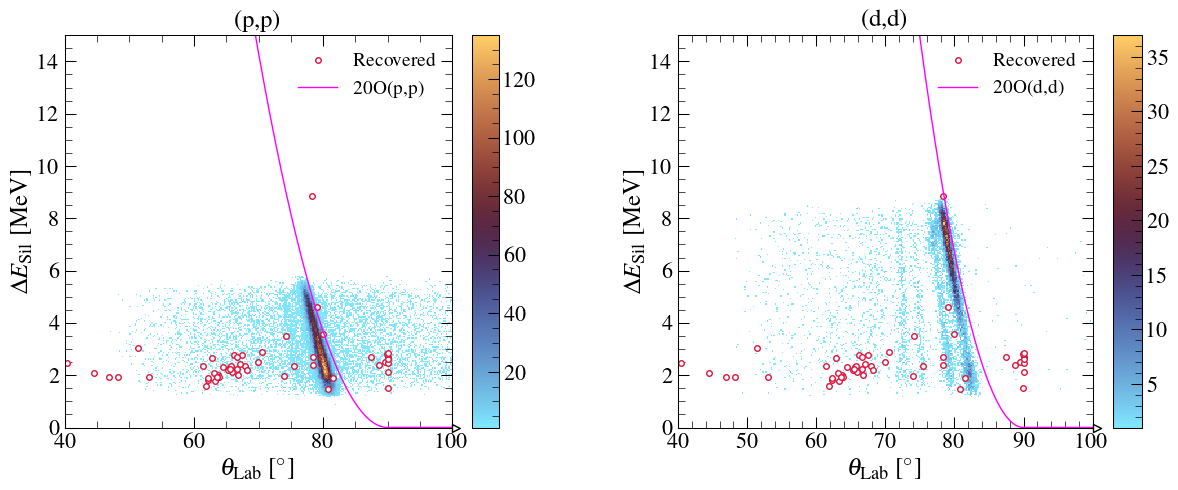

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5))

labels = ["(p,p)", "(d,d)"]
for i, exp in enumerate(exps):
    ax = axs.flatten()[i]
    hSimuKin = hist.Hist.new.Reg(300, 40, 100, label=r"$\theta_{\mathrm{Lab}}$ [$^{\circ}$]").Reg(300, 0, 15, label=r"$\Delta E_{\mathrm{Sil}}$ [MeV]").Double()
    hSimuKin.fill(exp["fThetaLight"], exp["fSilEs"].apply(lambda x: x[0]))
    hSimuKin.plot(ax=ax, cmin=1, cmap="managua_r")
    plt.plot(bad["angle"], rootbad["E0"], color="crimson", marker="o", ls="none", ms=4, label="Recovered")
    phys.KinInterface(f"20O{labels[i]}@700").plot_kin3(color="magenta", label=f"20O{labels[i]}")
    ax.legend(loc="upper right")
    ax.set_title(labels[i])

fig.tight_layout()

We have tested this with a simulation: punch-through events (from the g.s at 1st approximation) are the best canditates to reproduce our recovered bad events.

In [85]:
simus = []
for file in ["../../../Simulation/Macros/CodePaper/Outputs/punch_1H_1H.root", "../../../Simulation/Macros/CodePaper/Outputs/punch_2H_2H.root"]:
    up = uproot.open(f"{file}:MiniTree")
    simus.append(up.arrays(library="pd"))
    simus[-1]["ThetaLight"] = np.degrees(simus[-1]["ThetaLight"])

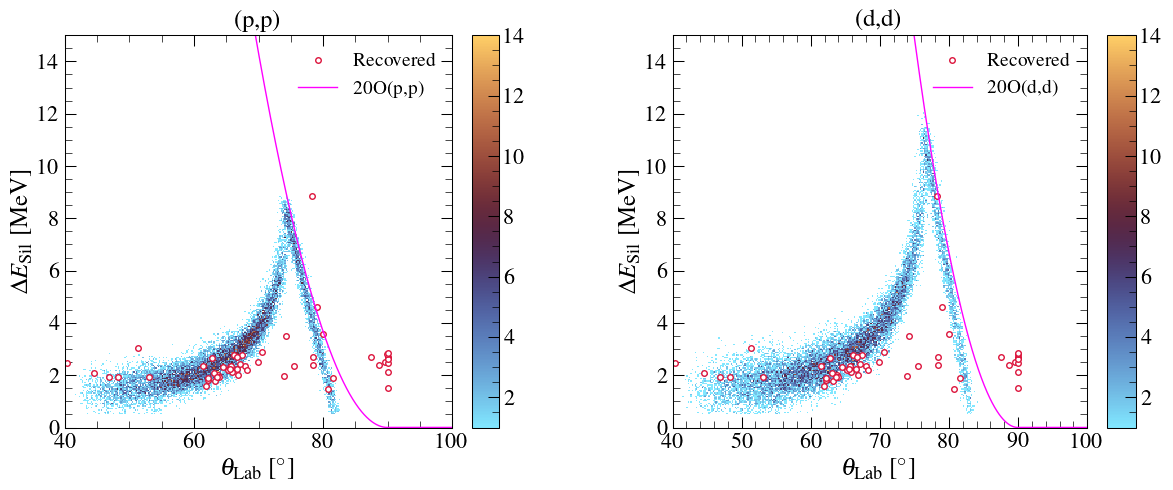

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5))

labels = ["(p,p)", "(d,d)"]
for i, simu in enumerate(simus):
    ax = axs.flatten()[i]
    hSimuKin = hist.Hist.new.Reg(300, 40, 100, label=r"$\theta_{\mathrm{Lab}}$ [$^{\circ}$]").Reg(300, 0, 15, label=r"$\Delta E_{\mathrm{Sil}}$ [MeV]").Double()
    hSimuKin.fill(simu["ThetaLight"], simu["DeltaE"])
    hSimuKin.plot(ax=ax, cmin=1, cmap="managua_r")
    plt.plot(bad["angle"], rootbad["E0"], color="crimson", marker="o", ls="none", ms=4, label="Recovered")
    phys.KinInterface(f"20O{labels[i]}@700").plot_kin3(color="magenta", label=f"20O{labels[i]}")
    ax.legend(loc="upper right")
    ax.set_title(labels[i])

fig.tight_layout()

Indeed this would agree with punch-through events from the ground state! Other excited could contribute but their xs are much lower. Hence, our reconstruction efficiency would be close to 100 %. And yet some events are missing due to some particularly large delta electron clusters that are mistaken by tracks. After inspecting ~ 600 binary events, I have seen only 4-5 of them.

### We can also compare the PID

In [87]:
with uproot.open("../../pid/Inputs/pid_side.root:PID_Tree") as t:
    pid = t.arrays(library="pd")

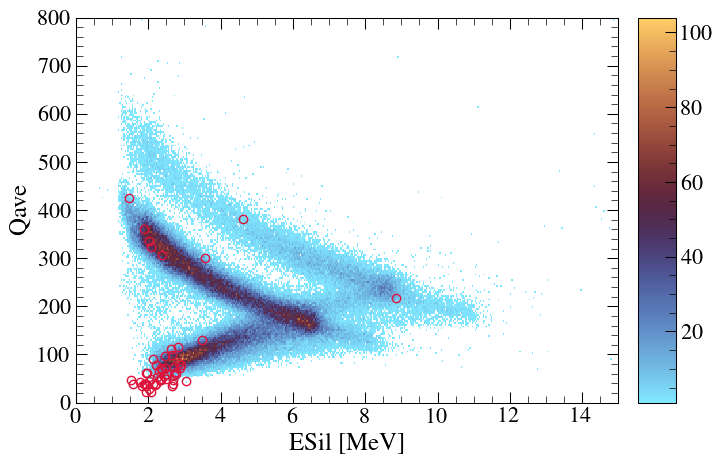

In [88]:
hPID = hist.Hist.new.Reg(400, 0, 15, label="ESil [MeV]").Reg(200, 0, 800, label="Qave").Double()
hPID.fill(pid["ESil0"], pid["fQave"])

hPID.plot(cmin=1, flow="none", cmap="managua_r")
plt.plot(rootbad["E0"], bad["qave"], ls="none", marker="o", markeredgecolor="crimson", markerfacecolor="none")